# Two-Body example notebook for polaris module

Yuri Shimane

This notebook demonstrates some functionalities for propagation in the Keplerian two-body system. 

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import Normalize
import plotly.express as px
import pandas as pd
from tqdm.auto import tqdm

In [2]:
import sys
sys.path.append('../')

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop

In [3]:
# get GM value
gm = sscs.get_gm("399")[0]

In [36]:
# simulate a bunch of trajectories with increasing periapsis altitudes
x_peris = np.linspace(7000.0, 12000, 20)
# list for storage
es, proplst = [], []
for xperi in x_peris:
    state0 = np.array([xperi, -3000, -200.0, 0.0, 7.6, 0.0])
    elts = kepl.sv2elts(state0, gm)
    es.append( la.norm(elts["evec"]) )
    proplst.append( prop.propagate_twobody(gm, state0, elts["period"]) )

In [37]:
elts

{'hvec': array([ 1520.,    -0., 91200.]),
 'incl': 0.016665123713943648,
 'evec': array([ 0.76886849,  0.24250393, -0.01281447]),
 'raan': 1.5707963267948966,
 'omega': 5.017877138963362,
 'theta': -0.5504341485068072,
 'period': 145014.62814158486,
 'semiMajorAxis': 59657.79803473653}

### Plot result

In [38]:
# create circle with radius of Earth for plotting
def plotCircle(x_center, y_center, radius, steps=2000):
    """Funtion generates coordinates of a circle for plotting"""
    thetas = np.linspace(0, 2*np.pi, steps)
    xs, ys = [], []
    for theta in thetas:
        xs.append( x_center + radius*np.cos(theta) )
        ys.append( y_center + radius*np.sin(theta) )
    return np.array(xs), np.array(ys)
xEarth_circ, yEarth_circ = plotCircle(0, 0, 6378.0)

In [39]:
def get_lc_traj_singleColor(xs, ys, c, vmin, vmax, cmap, lw=0.8):
    """
    Get line collection object a trajectory with a single color based on a colormap defined by vmin ~ vmax
    For plotting, run:
        line = ax.add_collection(lc)
        fig.colorbar(line, ax=ax, label="Colorbar label")
    
    Args:
        xs (np.array): array-like object of x-coordinates of the trajectory
        
    Returns:
        (obj): line collection object
    """
    # generate segments
    points = np.array([ xs , ys ]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    plt_color = c * np.ones((len(xs), ))
    # create color bar
    norm = plt.Normalize( vmin, vmax )
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    # Set the values used for colormapping
    lc.set_array( plt_color )
    lc.set_linewidth(lw)
    return lc

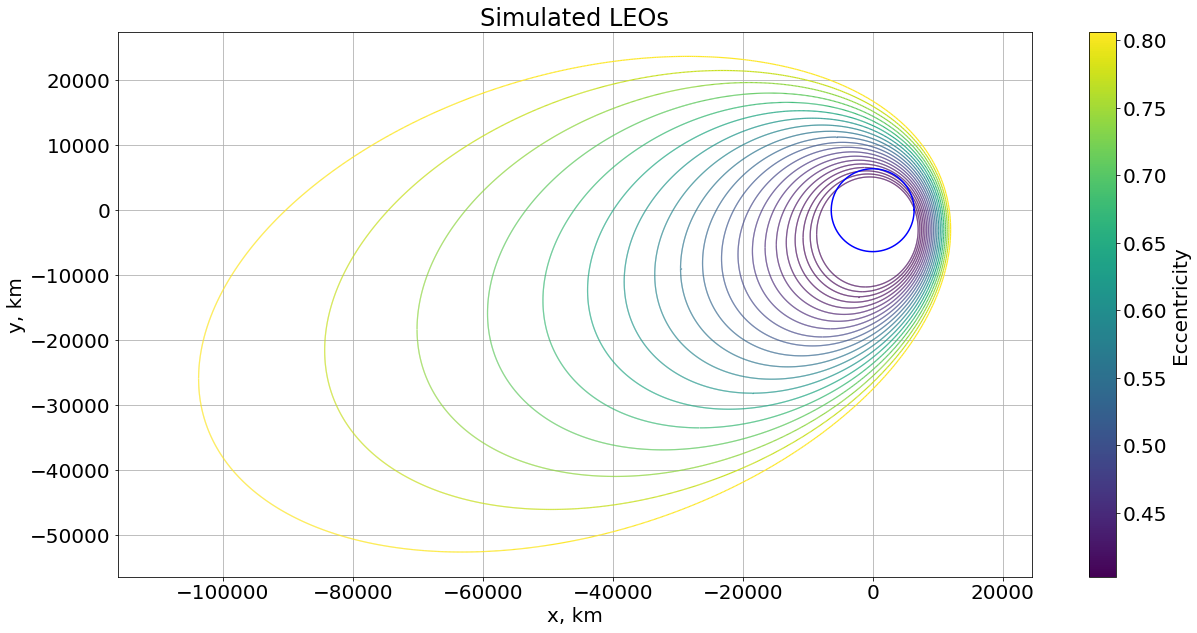

In [40]:
# plot transfers inside lunar SOI
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 1, figsize=(18, 10))

for idxTraj in tqdm(range(len(proplst))):
    lc = get_lc_traj_singleColor(xs=proplst[idxTraj]["xs"], ys=proplst[idxTraj]["ys"], 
                            c=es[idxTraj], vmin=min(es), vmax=max(es), cmap='viridis', lw=1.2)
    line = axs.add_collection(lc)
    
# display colorbar
fig.colorbar(line, ax=axs, label="Eccentricity")

axs.plot(xEarth_circ, yEarth_circ, c='b', linewidth=1.5)
axs.axis('equal')
axs.grid(True)
axs.set_xlabel('x, km')
axs.set_ylabel('y, km')
axs.set_title('Simulated LEOs')
#axs.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [41]:
data = [proplst[0]["xs"], proplst[0]["ys"], proplst[0]["zs"]]
df = pd.DataFrame(data, index=['xs', 'ys', 'zs']).T
fig = px.line_3d(df, x="xs", y="ys", z="zs")
fig.show()